# Patient-patient similarity network-based risk assessment of CVD(psnCVD)

---
### Table of contents
1. [Introduction](#intro)
2. [psnCVD pipeline](#pip) 
       a. [Data Pre-processing](#a) 
       b. [Patient Network Construction & Visualization](#b) 
       c. [Validation using cardiac outcomes and survival analysis](#c) 
       d. [Clinical variable interpretation](#d)
3. [References](#ref)


---
# <a name="intro"></a> Introduction
Recent advances in artificial intelligence and network science technologies offer valuable and increasingly useful network tools for deep phenotyping of patient heterogeneities as seen in patients who develop stroke, pulmonary vascular disease, as well as those seen in cardio-oncology. In this study, we develop a clinically actionable, network-based methodology (called patient-patient similarity network-based risk assessment of CVD or psnCVD) for unbiased cardiac risk stratification of cancer patients with cancer therapy-related cardiac dysfunction (CTRCD) using large-scale, longitudinal, heterogeneous patient data, including general demographics, Echo, laboratory testing, and cardiac factors. With the aid of psnCVD, patients of unknown status can be classified based on their similarity to patients with known status, offering precision medicine approaches to identify patients that are highly sensitive to CTRCD. Compared to traditional statistical risk models and ‘black box’ machine-learning methods, psnCVD excels at integrating heterogeneous patient data and generating interpretable mechanism models.



#### Project Dependency
```
numpy
pandas
matplotlib
seaborn
sklearn
lifelines
networkx
```



#### Project Structure
```
/patient_network.ipynb          .... this notebook
/data/                          .... input data folder
     /data.txt                  .... de-identified all data of the patients
     /label.txt                 .... CVD outcome
     /patient.txt               .... de-identified id
     /survival time.csv         .... patient survival information
     /!feature-merged.txt       .... variable list at 15% cytoff
/output/                        .... folder for output/intermediate result
       /network.txt             .... generated patient network
       /cluster.txt             .... patient cluster number
       /variable_network_c*.txt .... variable network for each patient cluster
```

---
# <a name="pip"></a> psnCVD pipeline

---
## <a name="a"></a> a Data Pre-processing

In [1]:
# Load modules
import os
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### <a name="a2"></a> Missing values are imputed:

In [2]:
from sklearn.impute import SimpleImputer

data = np.loadtxt("data/data.txt")

imp = SimpleImputer(missing_values=np.nan, strategy="mean")
imp.fit(data)
data = imp.transform(data)

### <a name="a2"></a> Z-scaling

In [3]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
scale.fit(data[:, 17:100])
data[:, 17:100] = scale.transform(data[:, 17:100])
np.save("data.npy", data)

### <a name="a2"></a> Patient cosine similarity calculation
For the construction of the patient-patient network, we computed the Cosine similarity for all pairs of patients. Other similarity metric, such as cosine similarity, was also tested and compared.

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

data_cos = cosine_similarity(data)
np.save("data-cos.npy", data_cos)

In [5]:
def Plot(data_set):
    m_pcc = data_set
    n = m_pcc.shape[0]
    plt.figure()
    plt.hist(m_pcc[np.triu_indices(n, k=1)], bins=100, log=True)
    plt.savefig("cosine.png")

#Plot(data_cos)

A cosine cutoff was used to determine if two patients should be connected. To identify the cutoff, we computed network densities at different cutoff values and selected the one yielding the lowest network density. Network density is defined as the ratio of the number of actual links to the number of all possible links among all the patients. The number of all possible links is calculated as n×(n-1)/2, where n is the number of patients in the network.

In [6]:
def View(fn):
    cutoffs = (0.5, 0.55, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.7, 0.75, 0.8, 0.85, 0.9)
    m_cos = data_cos
    for i in range(len(m_cos)):
        m_cos[i, i] = 0
    n = m_cos.shape[0]
    plot_node = []
    plot_link = []
    plot_dens = []
    for cutoff in cutoffs:
        # connected = abs(m_cos) > cutoff
        connected = m_cos > cutoff
        nodes = len(set(connected.nonzero()[0]))
        links = len(connected.nonzero()[0]) / 2
        density = 2 * links / nodes / (nodes - 1)
        #print(cutoff, nodes, links, density)
        plot_node.append(nodes)
        plot_link.append(links)
        plot_dens.append(density)
    return pd.DataFrame(np.array([cutoffs,plot_node,plot_link,plot_dens]).T,
                        columns=("Cutoff","Number of Nodes","Number of Links","Density"))

net_property = View("data")
net_property

,Cutoff,Number of Nodes,Number of Links,Density
0,0.50,4611.0,114909.0,0.010812
1,0.55,4426.0,54362.0,0.005551
2,0.60,3800.0,23330.0,0.003232
3,0.61,3612.0,19335.0,0.002965
4,0.62,3383.0,15850.0,0.002771
5,0.63,3152.0,13110.0,0.002640
6,0.64,2917.0,10707.0,0.002518
7,0.65,2669.0,8677.0,0.002437
8,0.66,2379.0,6976.0,0.002466
9,0.67,2096.0,5584.0,0.002543


Using this method, a cutoff of 0.62 was chosen, which resulted in a density of 0.24%. All patient pairs with |Cosine|>0.62 were then considered connected in the network. The final network contains 3,131 patients and 15,698 connections among them.

In [7]:
PATIENT = []
with open("data/patient.txt") as fi:
    for line in fi:
        PATIENT.append(line.strip())

N = len(PATIENT)


def Generate(fn, t_cos):
    m_cos = data_cos
    # count = [0, 0]
    with open("net-%s-%s.txt" % (fn, t_cos), "w") as fo:
        fo.write("patient1\tpatient2\n")
        for p1 in range(N):
            for p2 in range(p1 + 1, N):
                if m_cos[p1, p2] > t_cos:
                    if PATIENT[p1] and PATIENT[p2]:
                        fo.write("%s\t%s\n" % (PATIENT[p1], PATIENT[p2]))
Generate("data", 0.62)

## <a name="pip_b"></a> b Patient Network Construction & Visualization

### <a name="a3"></a> Patient clustering

To identify patient subgroups, we clustered the patients using their network profiles by K-means analysis.

In [8]:
import random
from sklearn.cluster import KMeans

random.seed(2048)

with open("data/patient.txt") as fi:
    patients = [line.strip("\n") for line in fi]


def do(name, path, nc):
    X = np.load(path)
    idx = np.arange(X.shape[0])
    y = KMeans(n_clusters=nc, random_state=20, n_jobs=1).fit_predict(X)
    with open("kmeans-%s.txt" % name, "w") as fo:
        fo.write("id\tcluster\n")
        for i, r in zip(idx, y):
            fo.write("%s\t%s\n" % (patients[i], r))
            
do("data-cos4", 'data-cos.npy', 4)

Save the clusting results: kmeans-data-cos4.txt

## <a name="pip_c"></a>c. Validation using cardiac outcomes and survival analysis

We then explored whether there are differences among the subgroups in terms of survival and de novo CTRCD risk. **We found that these four patient subgroups have distinct survival rates and de novo CTRCD risks.**

Load survival and cluster data:

In [9]:
# Death status: 0 alive; 1 death. Time means the years from the cancer initiation.
df_cluster = pd.read_csv("kmeans-data-cos4.txt", sep="\t")
Survival_status = pd.read_csv("data/survival time.csv")
survival_dataframe = pd.merge(df_cluster, Survival_status, how="outer", on="id")

Perform survival/risk analysis:

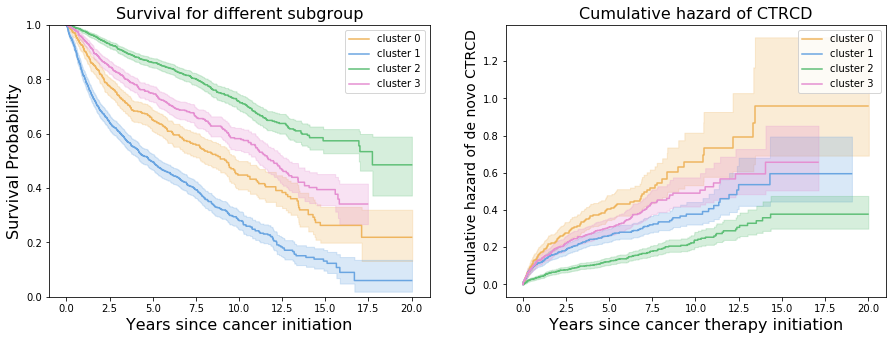

In [10]:
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
#survival analysis
df_su = survival_dataframe.sort_values(by=["cluster"]).dropna(subset=['survival_time'])
kmf = KaplanMeierFitter()
T = df_su["survival_time"]
E = df_su["Death_status"]
plt.figure(figsize=(15,5))
ax = plt.subplot(121)
for value, color in zip(df_su["cluster"].unique(), ["#efb55f",'#6aa5e1','#5fbf77','#e58fd1']):
    dem = df_su["cluster"] == value
    kmf.fit(T[dem], event_observed=E[dem], label="cluster %s" % value)
    kmf.plot(ax=ax,c=color)
plt.ylim(0, 1)
plt.title("Survival for different subgroup",fontsize=16)
plt.ylabel("Survival Probability", fontsize=16)
plt.xlabel("Years since cancer initiation",fontsize=16)
#Cumulative hazard
df_cardio = survival_dataframe.sort_values(by=["cluster"]).dropna(subset=['CTRCD'])
naf = NelsonAalenFitter()
T = df_cardio["denovo_CTRCD_time"]
E = df_cardio["CTRCD"]
ax = plt.subplot(122)
for value, color in zip(df_cardio["cluster"].unique(), ["#efb55f",'#6aa5e1','#5fbf77','#e58fd1']):
    dem = df_cardio["cluster"] == value
    naf.fit(T[dem], event_observed=E[dem], label="cluster %s " % value)
    naf.plot(ax=ax,c=color)
#plt.ylim(0, 1.5)
plt.title("Cumulative hazard of CTRCD",fontsize=16)
plt.ylabel("Cumulative hazard of de novo CTRCD", fontsize=14)
plt.xlabel("Years since cancer therapy initiation",fontsize=16);

The significances of the survial and the cumulative hazard are calculated as below:

In [11]:
# p value by logrank_test
from lifelines.statistics import multivariate_logrank_test
result_su = multivariate_logrank_test(df_su['survival_time'], df_su['cluster'], df_su['Death_status'])
result_su.test_statistic
print("Survival probability, p-value:",result_su.p_value)
result_cardio = multivariate_logrank_test(df_su['denovo_CTRCD_time'], df_su['cluster'], df_su['CTRCD'])
result_cardio.test_statistic
print("Cumulative incidence of de novo CTRCD, p-value:",result_cardio.p_value)

Survival probability, p-value: 1.2393598193788615e-144
Cumulative incidence of de novo CTRCD, p-value: 1.2311076279405487e-32


## <a name="pip_d"></a> d Clinical Variable Interpretation

We adopted a top-K percent strategy that uses the K% connections with the highest PCC for the construction of the network. To determine which K to use, we test the following percentages: 5%, 10%, 15%, and 20%. For example, using top-5%, all variable pairs with |PCC| greater than the absolute PCC at the top 5% were connected. Too few clinical variables were still present in the network when 5% and 10% was used. When 20% were used, we fund an increasing number of correlations with less significantly p-value (p > 0.05). Therefore, 15% was used for the final clinical variable network analysis.

### PCC caculation

In [12]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

data = np.load("data.npy")

CLUSTER = []
with open("kmeans-data-cos4.txt") as fi:
    next(fi)
    for line in fi:
        CLUSTER.append(int(line.strip("\n").split("\t")[1]))

CLUSTER = np.array(CLUSTER)
assert len(CLUSTER) == data.shape[0]


def Generate(mat, fn):
    print(fn)
    n = mat.shape[0]
    m_pcc = np.zeros((n, n))
    m_pvalue = np.zeros((n, n))
    for p1 in range(n):
        for p2 in range(p1 + 1, n):
            pcc, pvalue = pearsonr(mat[p1], mat[p2])
            m_pcc[p1, p2] = m_pcc[p2, p1] = pcc
            m_pvalue[p1, p2] = pvalue
    m_pvalue[np.triu_indices(n, k=1)] = multipletests(m_pvalue[np.triu_indices(n, k=1)], method="bonferroni")[1]
    np.save("pcc-%s.npy" % fn, m_pcc)
    np.save("pvalue-%s.npy" % fn, m_pvalue + m_pvalue.T)


Generate(data[CLUSTER == 0].T, "c0")
Generate(data[CLUSTER == 1].T, "c1")
Generate(data[CLUSTER == 2].T, "c2")
Generate(data[CLUSTER == 3].T, "c3")

c0
c1
c2
c3


In [13]:
def Range(a, b):
    return list(range(a, b + 1))


TO_MERGE = [
    Range(50, 54) + [100, 101],
    Range(55, 59),
    Range(60, 64) + [102, 103],
    Range(65, 69) + [104, 105],
    Range(70, 74) + [106, 107],
    Range(75, 79),
    Range(80, 84),
    Range(85, 89),
    Range(90, 94) + [108, 109],
    Range(95, 99) + [110, 111],
]


def Merge(fn):
    m_pcc = np.load("pcc-%s.npy" % fn)
    m_pvalue = np.load("pvalue-%s.npy" % fn)
    to_delete = sum(TO_MERGE, [])
    to_keep = [i for i in range(m_pcc.shape[0]) if i not in to_delete]

    temp = []
    temp_pv = []
    for x in TO_MERGE:
        temp.append(m_pcc[x])
        temp_pv.append(m_pvalue[x])
    temp_pv2 = np.array([t2[abs(t).argmax(0), np.arange(len(to_keep) + len(to_delete))] for t, t2 in zip(temp, temp_pv)])
    m_pvalue = np.vstack((m_pvalue[to_keep], temp_pv2)).T
    temp2 = np.array([t[abs(t).argmax(0), np.arange(len(to_keep) + len(to_delete))] for t in temp])
    m_pcc = np.vstack((m_pcc[to_keep], temp2)).T

    temp = []
    temp_pv = []
    for x in TO_MERGE:
        temp.append(m_pcc[x])
        temp_pv.append(m_pvalue[x])
    temp_pv2 = np.array([t2[abs(t).argmax(0), np.arange(len(to_keep) + len(TO_MERGE))] for t, t2 in zip(temp, temp_pv)])
    m_pvalue = np.vstack((m_pvalue[to_keep], temp_pv2))
    temp2 = np.array([t[abs(t).argmax(0), np.arange(len(to_keep) + len(TO_MERGE))] for t in temp])
    m_pcc = np.vstack((m_pcc[to_keep], temp2))

    for i in range(m_pcc.shape[0]):
        m_pcc[i, i] = 0
        m_pvalue[i, i] = 1

    m_pcc = m_pcc[17:, 17:]
    m_pvalue = m_pvalue[17:, 17:]

    np.save("merged-pcc-%s" % fn, m_pcc)
    np.save("merged-pvalue-%s" % fn, m_pvalue)
    np.save("merged-pvalue-all-%s" % fn, m_pvalue[np.triu_indices(m_pvalue.shape[0], k=1)])


Merge("c0")
Merge("c1")
Merge("c2")
Merge("c3")

### PCC cutoff - top-K percent strategy

In [14]:
N = 43
def Cutoff(fn, ratio):
    m_pcc = np.load("merged-pcc-%s.npy" % fn)
    m_pvalue = np.load("merged-pvalue-%s.npy" % fn)
    pccs = sorted(abs(m_pcc[np.triu_indices(N, k=1)]))
    cutoff = pccs[int(len(pccs) * (1 - ratio))]
    pvs = []
    for p1 in range(N):
        for p2 in range(p1 + 1, N):
            if abs(m_pcc[p1, p2]) > cutoff:
                pvs.append(m_pvalue[p1, p2])
    print(cutoff, max(pvs))
    
Cutoff("c0", 0.05)
Cutoff("c1", 0.05)
Cutoff("c2", 0.05)
Cutoff("c3", 0.05)
print()

Cutoff("c0", 0.10)
Cutoff("c1", 0.10)
Cutoff("c2", 0.10)
Cutoff("c3", 0.10)
print()

Cutoff("c0", 0.15)
Cutoff("c1", 0.15)
Cutoff("c2", 0.15)
Cutoff("c3", 0.15)
print()

Cutoff("c0", 0.20)
Cutoff("c1", 0.20)
Cutoff("c2", 0.20)
Cutoff("c3", 0.20)

0.35913419126783075 1.6854323675330396e-17
0.3035658502050491 1.6565466384668552e-24
0.22787704332788694 4.9038077961165344e-20
0.3320181029075215 1.6772449339211617e-22

0.2454242288498892 2.8848550700906253e-06
0.21589444971271216 3.739944850535703e-11
0.1638733011520935 4.4809659822839226e-09
0.2053431937990049 9.247278289828377e-07

0.20754367104836535 0.0007974283564370026
0.17743695334626033 1.5511821506549768e-06
0.1385261391052093 2.0110737583395028e-05
0.15577046048317275 0.008197838141787242

0.1842165073198475 0.021601451994486535
0.14873378022829267 0.000613716936013505
0.11545693583404243 0.0051593467380543715
0.1307419330562271 0.33550353869027055


### Clinical variable network generation

In [15]:
N = 43
FEATURES = open("data/!feature-merged.txt").read().splitlines()
assert len(FEATURES) == N


def Generate(fn, ratio):
    m_pcc = np.load("merged-pcc-%s.npy" % fn)
    pccs = sorted(abs(m_pcc[np.triu_indices(N, k=1)]))
    cutoff = pccs[int(len(pccs) * (1 - ratio))]

    with open("net-top%.2f-%s.txt" % (ratio, fn), "w") as fo:
        #fo.write("source\ttarget\tabspcc\n")
        for p1 in range(N):
            for p2 in range(p1 + 1, N):
                if abs(m_pcc[p1, p2]) > cutoff:
                    fo.write("%s\t%s\t%.3f\n" % (FEATURES[p1], FEATURES[p2], abs(m_pcc[p1, p2])))


Generate("c0", 0.15)
Generate("c1", 0.15)
Generate("c2", 0.15)
Generate("c3", 0.15)

###  Variable Network Exploration

We utilized the NetworkX package based on Python 3.7 platform to study the properties of the clinical variable networks, and used two approaches (degree and betweenness centrality) for evaluation. 

In [16]:
import re
import networkx as nx 

# Degree
listname= ["net-top0.15-c0.txt","net-top0.15-c1.txt","net-top0.15-c2.txt","net-top0.15-c3.txt"]
v_degree = pd.DataFrame(columns=["id"])
for i in listname:
    cluster = re.search(r'.+(c[0-3]).+', i).group(1)
    node_name=[]
    node_degree =[]
    df = pd.read_csv(i,sep="\t")
    df.columns = ['source', 'target',"pcc"]
    G = nx.from_pandas_edgelist(df, 'source', 'target')
    for j in G.degree():
        node_name.append(j[0])
        node_degree.append(j[1])
    sheet = {'id':node_name,'variable_degree':node_degree}
    df = pd.DataFrame.from_dict(sheet)
    df.rename(columns={"variable_degree":str(cluster)},inplace = True)
    v_degree = pd.merge(v_degree, df,how = "outer",on =["id"])

In [17]:
#betweenness_centrality
v_centrality = pd.DataFrame(columns=["id"])
for i in listname:
    cluster = re.search(r'.+(c[0-3]).+', i).group(1)
    node_name=[]
    betweenness_centrality =[]
    df = pd.read_csv(i,sep="\t")
    df.columns = ['source', 'target',"pcc"]
    G = nx.from_pandas_edgelist(df, 'source', 'target')
    for j in nx.betweenness_centrality(G).items():
        node_name.append(j[0])
        betweenness_centrality.append(j[1])
    sheet = {'id':node_name,'v_centrality':betweenness_centrality}
    df = pd.DataFrame.from_dict(sheet)
    df.rename(columns={"v_centrality":str(cluster)},inplace = True)
    v_centrality = pd.merge(v_centrality, df,how = "outer",on =["id"])


---
# <a name="ref"></a> References

* Cheng F (2019) Methods in Molecular Biology. 30:75-97.
* Huang Y, Fang J,…, Cheng F (2019) Cell Chemical Biology. 28:1-16.
* Cheng F, Lu W, …, Loscalzo J (2019) Nature Communications. in press. 
* Cheng F, Kovacs I, Barabasi AL (2019) Nature Communications. 10:1197.
* Cheng F, Desai JR, …, Loscalzo J (2018) Nature Communications. 9:2691.
* Cheng F, Loscalzo J (2018) Trends in Molecular Medicine. 24(3):239-241.
* Cheng F, Loscalzo J (2017) Trends in Immunology. 38(2):77-78.